In [1]:
#import relevant libraries 
import pandas as pd
import plotly.express as px
import panel as pn
import hvplot.pandas
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta,date
from pandas import DataFrame



In [2]:
## Get Market Data for S&P500 
#engage API keys by activating .env file for Alpaca Api
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

#function to read the api data for stock ticker
#returns dataframe of closing price and daily returns for a given ticker symbol
def get_ticker_data(api,ticker):
    #load in historical data for provided ticker
    stock_data_df = api.alpha_vantage.historic_quotes(ticker, adjusted=True, output_format='pandas')

    #Clean Data
    

    #Sort earliest to latest. so that .pct_change() function works right.
    stock_data_df.sort_index(inplace=True, ascending=True)

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    # drop duplicates
    stock_data_df.drop_duplicates(inplace=True)

    #count nulls 
    stock_data_df.isnull().sum()

    #create a dataframe column for the daily returns (pct_change) values and concat 
    returns_df = stock_data_df['5. adjusted close'].pct_change()
    stock_data_df = pd.concat([stock_data_df, returns_df], axis="columns", join="inner")

    #Change column names to avoid confusion
    columns = ['Open','High','Low','Close','Adjusted Close','Volume','Dividend Amount','Split Coefficient','Daily Returns']
    stock_data_df.columns = columns

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    #drop duplicates
    stock_data_df.drop_duplicates(inplace=True) 
    return stock_data_df

In [5]:
stock_data_df=get_ticker_data(api,'SPY')

In [6]:
#Bollinger Bands Simulator to assess the asset and choose ideal, optimized bollinger window, no of standard deviations, and period.
class BollingerBandsSimulator:

    def __init__(self, stock_data_df, period, bollinger_window, no_of_std, figsize=None):
        self.stock_data_df = stock_data_df
        #self.from_date = from_date
        self.period = period
        self.bollinger_window = bollinger_window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_dataframe(self):
        self.stock_data_df.sort_index(ascending=True, inplace=True)
        
                
    def _bollinger_bands(self):
        
        self.stock_data_df['Bollinger middle'] = self.stock_data_df['Close'].rolling(self.bollinger_window).mean()
        #self.stock_data_df['Bollinger Long']= self.stock_data_df['Close'].rolling(self.bollinger_window_long).mean()
        self.stock_data_df['Bollinger STD'] = self.stock_data_df['Close'].rolling(self.bollinger_window).std()

        self.stock_data_df['Bollinger Upper']  = self.stock_data_df['Bollinger middle'] + (self.stock_data_df['Bollinger STD'] * self.no_of_std)
        self.stock_data_df['Bollinger Lower']  = self.stock_data_df['Bollinger middle'] - (self.stock_data_df['Bollinger STD'] * self.no_of_std)


    def _calculate_signals(self):
        self.stock_data_df['Signal'] = None

        mode = 'Open'
        for index in range(len(self.stock_data_df)):
            if index == 0:
                continue

            row = self.stock_data_df.iloc[index]
            prev_row = self.stock_data_df.iloc[index - 1]

            # open?
            if mode == 'Open' and row['Close'] < row['Bollinger Lower'] and prev_row['Close'] > prev_row['Bollinger Lower']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('Signal')] = 1
                mode = 'Close'

            # close?
            if mode == 'Close' and row['Close'] > row['Bollinger Upper'] and prev_row['Close'] < prev_row['Bollinger Upper']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('Signal')] = -1
                mode = 'Open'        
        
    def _returns(self):
        self.stock_data_df['Signal'].fillna(method='ffill', inplace=True)
        self.stock_data_df['Daily Return'] = self.stock_data_df['Close'].pct_change()
        self.stock_data_df['Strategy Return'] = self.stock_data_df['Daily Return'] * self.stock_data_df['Signal']

    def _plot_returns(self):
        self.stock_data_df['Strategy Return'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_dataframe()
        self._bollinger_bands()
        self._calculate_signals()
        self._returns()
        self._plot_returns()

        return (
            self.period, 
            self.bollinger_window, 
            self.no_of_std, 
            self.stock_data_df['Strategy Return'].sum()
        )

('24H', 10, 1.5, -6.829763399053151)

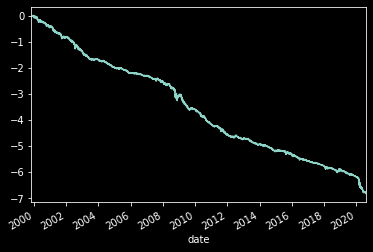

In [7]:
simulator = BollingerBandsSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period="24H", 
    bollinger_window=10, 
    no_of_std=1.5
)
simulator.simulate()

In [9]:
#Bollinger Band Optimal Calculation
def Bollinger_Band_Optimal(stock_data_df):
    windows = np.linspace(10, 100, 5, dtype=int)
    stds = np.linspace(1, 3, 5)
    periods = np.array([12, 48])

    result_df = pd.DataFrame({
        'period': [], 
        'bollinger_window': [],
        'no_of_std': [],
        'result': []
    })
    for window in windows:
        for std in stds:
            for period in periods:
                simulator = BollingerBandsSimulator(
                    stock_data_df, 
                    #from_date 
                    period="{}H".format(period), 
                    bollinger_window=window, 
                    no_of_std=std,
                    figsize=(14, 7)
                )
                period, bollinger_window, no_of_std, result = simulator.simulate()
                result_df = result_df.append({
                    'period': period, 
                    'bollinger_window': bollinger_window, 
                    'no_of_std': no_of_std, 
                    'result': result
                }, ignore_index=True)
    bollinger_result=result_df.sort_values(by=['result'], ascending=False)[:5]
    return bollinger_result

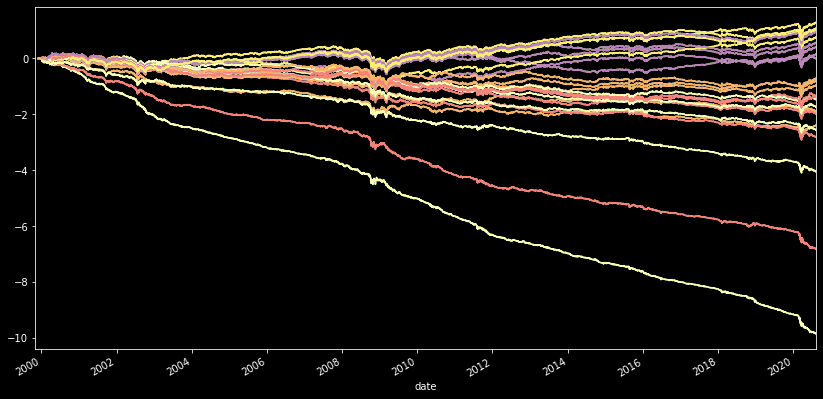

In [10]:
bollinger_result=Bollinger_Band_Optimal(stock_data_df)

In [21]:
opt_bollinger_df=bollinger_result.head()
opt_bollinger_df

period  bollinger_window  no_of_std    result
38    12H              77.0        3.0  1.284412
39    48H              77.0        3.0  1.284412
49    48H             100.0        3.0  1.075943
48    12H             100.0        3.0  1.075943
19    48H              32.0        3.0  0.997140

In [19]:
bollinger_window=opt_bollinger_df['bollinger_window'].iloc[0]
no_of_std=opt_bollinger_df['no_of_std'].iloc[0]

In [28]:
type(bollinger_window)

numpy.float64

In [ ]:
# function to get the SMA of the returns
# return EMA signal values dataframe
def get_EMA(stock_data_df,ticker,short_window,long_window): #typical short is 50 and long is 100
    # Grab just the `date` and `close` from the dataset
    ema_signals = stock_data_df.loc[:, ['Close']].copy()

    # Generate the short and long exponential moving averages (50 and 100 days, respectively)
    ema_signals["EWM50"] = ema_signals['Close'].ewm(span=short_window).mean()
    ema_signals["EWM100"] = ema_signals['Close'].ewm(span=long_window).mean()
    ema_signals["Signal"] = 0.0

    # Generate the trading signal 0 or 1,
    # where 0 is when the EWM50 is under the EWM100, and
    # where 1 is when the EWM50 is higher (or crosses over) the SMA100
    ema_signals["Signal"][short_window:] = np.where(
    ema_signals["EWM50"][short_window:] > ema_signals["EWM100"][short_window:], 1.0, 0.0)
    # Calculate the points in time at which a position should be taken, 1 or -1
    ema_signals["Entry/Exit"] = ema_signals["Signal"].diff()
    return ema_signals

In [42]:
stock_data_df.head()

Open      High       Low     Close  Adjusted Close     Volume  \
date                                                                            
1999-11-02  135.9687  137.2500  134.5937  134.5937         91.3152  6516900.0   
1999-11-03  136.0000  136.3750  135.1250  135.5000         91.9301  7222300.0   
1999-11-04  136.7500  137.3593  135.7656  136.5312         92.6297  7907500.0   
1999-11-05  138.6250  139.1093  136.7812  137.8750         93.5414  7431500.0   
1999-11-08  137.0000  138.3750  136.7500  138.0000         93.6262  4649200.0   

            Dividend Amount  Split Coefficient  Daily Returns  \
date                                                            
1999-11-02              0.0                1.0      -0.007147   
1999-11-03              0.0                1.0       0.006734   
1999-11-04              0.0                1.0       0.007610   
1999-11-05              0.0                1.0       0.009842   
1999-11-08              0.0                1.0       0.000907   

            Bollinger middle  Bollinger STD  Bollinger Upper  Bollinger Lower  \
date                                                                            
1999-11-02               NaN            NaN              NaN              NaN   
1999-11-03               NaN            NaN              NaN              NaN   
1999-11-04               NaN            NaN              NaN              NaN   
1999-11-05               NaN            NaN              NaN              NaN   
1999-11-08               NaN            NaN              NaN              NaN   

            Signal  Daily Return  Strategy Return  
date                                               
1999-11-02     NaN           NaN              NaN  
1999-11-03     NaN      0.006734              NaN  
1999-11-04     NaN      0.007610              NaN  
1999-11-05     NaN      0.009842              NaN  
1999-11-08     NaN      0.000907              NaN

In [40]:
# function to get the Bolinger Bands of the returns
# return Bolinger Band signal values dataframe
def get_Bollinger(stock_data_df,ticker,bollinger_window,no_of_std):
    # Grab just the `date` and `close` from the dataset
    bollinger_signals = stock_data_df.loc[:, ['Close']].copy()
    bollinger_window=int(bollinger_window)
    no_of_std=int(no_of_std)

    # Calculate rolling mean and standard deviation
    bollinger_signals['Bollinger middle'] = bollinger_signals['Close'].rolling(bollinger_window).mean()
    bollinger_signals['Bollinger STD'] = bollinger_signals['Close'].rolling(bollinger_window).std()

    # Calculate upper and lowers bands of bollinger band
    bollinger_signals['Bollinger Upper']  = bollinger_signals['Bollinger middle'] + (bollinger_signals['Bollinger STD'] * no_of_std)
    bollinger_signals['Bollinger Lower']  = bollinger_signals['Bollinger middle'] - (bollinger_signals['Bollinger STD'] * no_of_std)


    #Calculate the Signal Value for Bollinger
    bollinger_signals['Entry/Exit'] = None

    mode = 'Open'
    for index in range(len(bollinger_signals)):
        if index == 0:
                    continue

        row = bollinger_signals.iloc[index]
        prev_row = bollinger_signals.iloc[index - 1]

                # open?
        if mode == 'Open' and row['Close'] < row['Bollinger Lower'] and prev_row['Close'] > prev_row['Bollinger Lower']:
            bollinger_signals.iloc[index, bollinger_signals.columns.get_loc('Entry/Exit')] = 1
            mode = 'Close'

                # close?
        if mode == 'Close' and row['Close'] > row['Bollinger Upper'] and prev_row['Close'] < prev_row['Bollinger Upper']:
            bollinger_signals.iloc[index, bollinger_signals.columns.get_loc('Entry/Exit')] = -1
            mode = 'Open'
    #bollinger_signals.dropna(inplace=True)
    
    return bollinger_signals

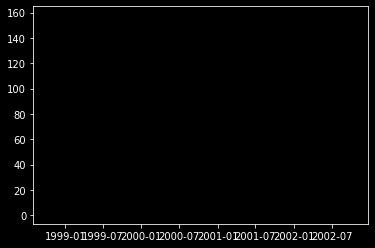

In [41]:
bollinger_signals=get_Bollinger(stock_data_df,'SPY',bollinger_window,no_of_std)
plt.plot(bollinger_signals)

In [39]:
bollinger_signals.head()

Close  Bollinger middle  Bollinger STD  Bollinger Upper  \
date                                                                     
1999-11-02  134.5937               NaN            NaN              NaN   
1999-11-03  135.5000               NaN            NaN              NaN   
1999-11-04  136.5312               NaN            NaN              NaN   
1999-11-05  137.8750               NaN            NaN              NaN   
1999-11-08  138.0000               NaN            NaN              NaN   

            Bollinger Lower Entry/Exit  
date                                    
1999-11-02              NaN       None  
1999-11-03              NaN       None  
1999-11-04              NaN       None  
1999-11-05              NaN       None  
1999-11-08              NaN       None

In [ ]:
# function to get the MACD Value of the returns
# return MACD signal values dataframe
def get_MACD(stock_data_df,ticker, span1, span2,span3): ##typically span = 12, 26, 9
    # Grab just the `date` and `close` from the dataset
    macd_signals = stock_data_df.loc[:, ['Close']].copy()

    
    exp1 = macd_signals.Close.ewm(span1, adjust=False).mean()
    exp2 = macd_signals.Close.ewm(span2, adjust=False).mean()
    macd = exp1-exp2
    macd_out = macd.ewm(span3, adjust=False).mean()
    
    macd_signals["Signal"] = np.where(macd > macd_out, 1.0, 0.0)
    macd_signals["MACD Entry/Exit"] = mac_signals["Signal"].diff()

    return macd_signals


In [ ]:
#function to get all trading signals
#return data frame holding trading signals
def get_trading_signals(ema_signal_df,boligner_signals_df,macd_signals_df):
    trading_signals_df=pd.concat([ema_signal_df, bolinger_signal_df,mcad_signal_df],axis=1,    join="inner")
    trading_signals_df['Signal']=trading_signals_df['EMA Signal']+ trading_signals_df['Bolinger Signal']+ trading_signals_df['MACD Signal']
    trading_signals_df['Overall Entry/Exit']=trading_signals_df['Signal'].diff()
    return trading_signals_df

In [ ]:

#Plot Signals and Indicators Against Price
def plot_signals(trading_signals_df, ema_signals, mac_signals)
    # Visualize exit position relative to close price
    exit = trading_signals_df['Overall Entry/Exit'] == -1.0].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = trading_signals_df['Overall Entry/Exit'] == 1.0].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Visualize close price for the investment
security_close = trading_signals_df[[f"{ticker}S&P 500 close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = ema_signals[['EWM50', 'EWM100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize bolinger bands
#bolinger_bands = Bolinger_signal_df[['EWM50', 'EWM100']].hvplot(
#    ylabel='Price in $',
#    width=1000,
#    height=400
#)

# Visualize moving averages
#macd = macd_signals[['EWM50', 'EWM100']].hvplot(
#    ylabel='Price in $',
#    width=1000,
#    height=400
#)

# Overlay plots
stock_signals_plot = security_close * moving_avgs * entry * exit
stock_signals_plot.opts(xaxis=None, title =f"Entry/Exit {ticker} Signals")